In [1]:
DATASET = 'full'
OUTNAME = 'SAGE_scales' #'SAGE'
IRT_DATASET = 'scales_' + DATASET
NPERMS = 10
DIFFICULTY_BINS = 10


In [2]:
import sys
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
import gc
from sklearn.manifold import TSNE
import seaborn as sns
from cluster_utils import evaluate_items
from vis_utils import (visualize_students, visualize_edges_age, visualize_edges, visualize_items, myresults, FIGSIZE,
CLUSTER_LABELS,  AGE_THR, DPI, CPU_Unpickler, plot_clustering, FONTSCALE)
sns.set_theme(context='talk', style='white', font_scale=FONTSCALE)

FILENAME = f'{OUTNAME}_{DATASET}'
EQUAL_AXES=False
MINSAMPLES = 10 #if DATASET in ['matrix', 'topic'] else 10

RELOAD = False

In [3]:
FILENAME

'SAGE_scales_full'

In [4]:
torch.cuda.empty_cache()
device = 'cpu'
model = torch.load(f'./results/{FILENAME}.pth.tar', map_location=torch.device('cpu'))

In [5]:
with open(f'./results/{FILENAME}_aux_data.pkl', 'rb') as handle:
    aux_data = CPU_Unpickler(handle).load()
    
(df, df_student, df_item, df_edge, 
            train_losses, #test_losses, test_aucs,
            train_edge_indices, val_edge_indices, test_edge_indices, 
            data, train_data, val_data, test_data,
            unique_scales, unique_domains, unique_matdiff, 
            DATA_FILE) = aux_data
print(df_item.shape)
try:
    # if IRT data exists, take item parameters
    with open(f'./results/IRT_{IRT_DATASET}_aux_data_IRT1.pkl', 'rb') as handle:
        aux_data = CPU_Unpickler(handle).load()

    (_, _, df_item_IRT, *_) = aux_data
    df_item = df_item.join(df_item_IRT[['IRT1_difficulty', 'IRT1_discrimination', 'IRT1_discrimination_transf']])
except:
    print('IRT1 not found')
    
print(df_item.shape)

(35087, 8)
(35087, 11)


In [6]:
if RELOAD:
    df = load_data_heterogeneous(DATA_FILE)
    data, df_student, df_item, df_edge = create_data_object_heterogeneous(df)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1522261


In [8]:
print(data)

HeteroData(
  student={
    node_id=[91677],
    x=[91677, 2],
  },
  item={
    node_id=[35087],
    x=[35087, 11],
  },
  (student, responds, item)={
    edge_index=[2, 33767508],
    edge_attr=[33767508, 2],
    y=[33767508],
  },
  (item, rev_responds, student)={
    edge_index=[2, 33767508],
    y=[33767508],
  }
)


In [9]:
if '_RT_' in OUTNAME:
    
    pars = model(data)
    npars = pars.shape[1]

    if npars == 6:
        tau_s, theta_s, a_s, theta_i, a_i, bias_i = torch.chunk(pars, npars, dim=1)
        print(pars.shape)
        NBINS=100
        fig, ax = plt.subplots(2, 3, figsize=(16, 14))
        ax[0, 0].hist(tau_s.detach().numpy(), bins=NBINS)
        ax[0, 1].hist(theta_s.detach().numpy(), bins=NBINS)
        ax[0, 2].hist(a_s.detach().numpy(), bins=NBINS)
        
        ax[1, 0].hist(theta_i.detach().numpy(), bins=NBINS)
        ax[1, 1].hist(a_i.detach().numpy(), bins=NBINS)
        ax[1, 2].hist(bias_i.detach().numpy(), bins=NBINS)
        
        ax[0, 0].set_title('tau_s')
        ax[0, 1].set_title('theta_s')
        ax[0, 2].set_title('a_s')
        ax[1, 0].set_title('theta_i')
        ax[1, 1].set_title('a_i')
        ax[1, 2].set_title('bias_i')
        
        plt.show()
    else:
        tau_s, theta_s, a_s, tau_i, theta_i, a_i, bias_i = torch.chunk(pars, npars, dim=1)
        print(pars.shape)
        NBINS=100
        fig, ax = plt.subplots(2, 4, figsize=(16, 14))
        ax[0, 0].hist(tau_s.detach().numpy(), bins=NBINS)
        ax[0, 1].hist(theta_s.detach().numpy(), bins=NBINS)
        ax[0, 2].hist(a_s.detach().numpy(), bins=NBINS)
        
        ax[1, 0].hist(tau_i.detach().numpy(), bins=NBINS)
        ax[1, 1].hist(theta_i.detach().numpy(), bins=NBINS)
        ax[1, 2].hist(a_i.detach().numpy(), bins=NBINS)
        ax[1, 3].hist(bias_i.detach().numpy(), bins=NBINS)
        
        ax[0, 0].set_title('tau_s')
        ax[0, 1].set_title('theta_s')
        ax[0, 2].set_title('a_s')
        ax[1, 0].set_title('tau_i')
        ax[1, 1].set_title('theta_i')
        ax[1, 2].set_title('a_i')
        ax[1, 3].set_title('bias_i')
        
        plt.show()
        

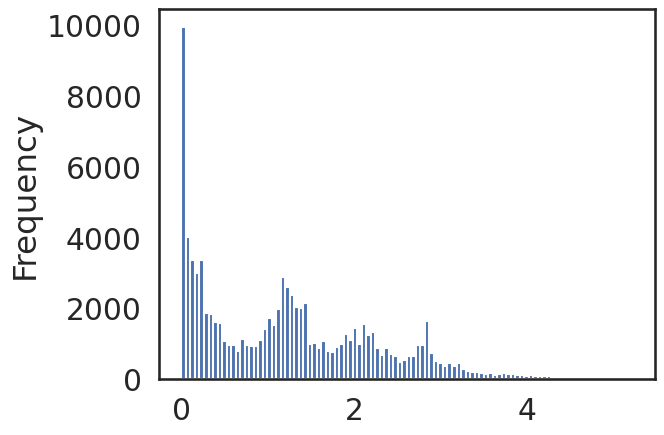

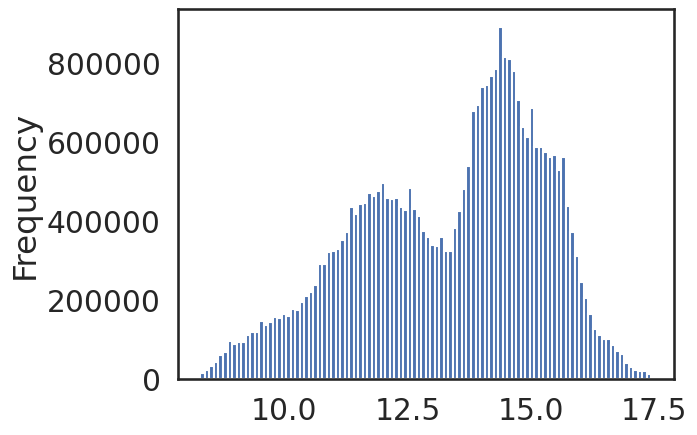

In [10]:
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())
fig = plt.figure()
age_ranges.plot.hist(bins=100)
plt.show()

fig = plt.figure()
df.age.plot.hist(bins=100)
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())

plt.show()

236.0

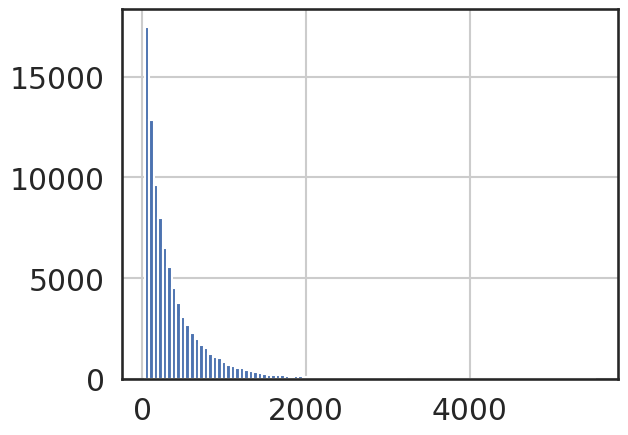

In [11]:
# different items per student
df.groupby(['studentId']).code.nunique().hist(bins=100)
df.groupby(['studentId']).code.nunique().median()


10.0

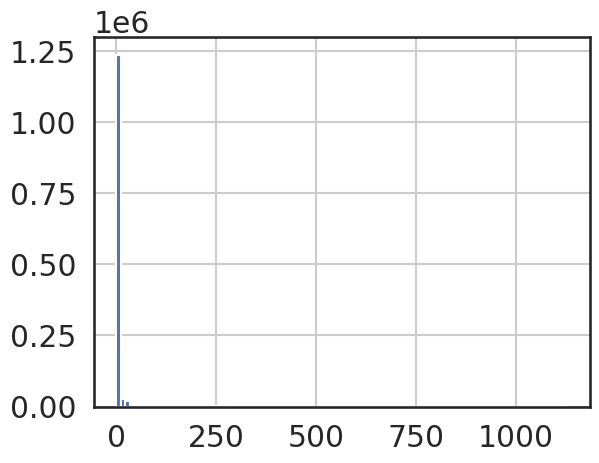

In [12]:
df.groupby(['assessmentId']).code.nunique().hist(bins=100)
df.groupby(['assessmentId']).code.nunique().median()

In [13]:
age_ranges.mean()

1.2189035417825627

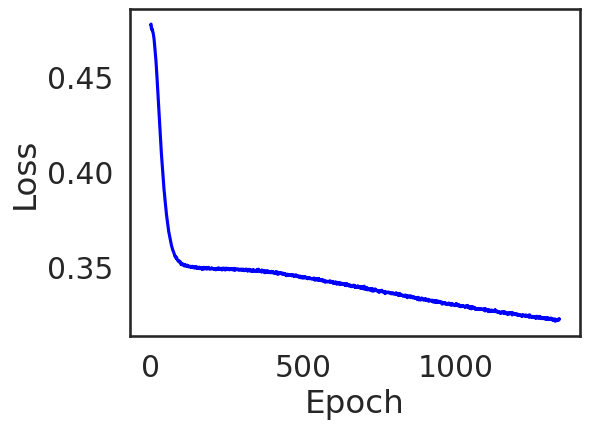

In [14]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_losses.png', dpi=DPI)

In [15]:
df.head()

,index,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,...,school_postcode,canton,school_code,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
1,1,0,1,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
2,2,0,2,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
3,3,0,3,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
4,4,0,4,1.0,0.0,fles,F.2.A.1.b.3,-0.49488,Berichte,NaN,...,4057,Basel-Stadt,04-052,0.657010,2.727266,3,1.10,,,f


df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)

df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


In [16]:
from scipy.stats import pearsonr
dff = df_item[['IRT1_difficulty', 'IRT1_discrimination_transf', 'IRT_difficulty', 'IRT1_discrimination',]].dropna()
print(pearsonr(dff['IRT1_discrimination'], dff['IRT1_discrimination_transf']))
print(pearsonr(dff['IRT1_difficulty'], dff['IRT_difficulty']))

PearsonRResult(statistic=0.9524659395782977, pvalue=0.0)
PearsonRResult(statistic=0.6554904281542216, pvalue=0.0)


plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)


if DATASET in ['matrix', 'topic']:
    sys.exit()

In [17]:
myresults.output_stats()

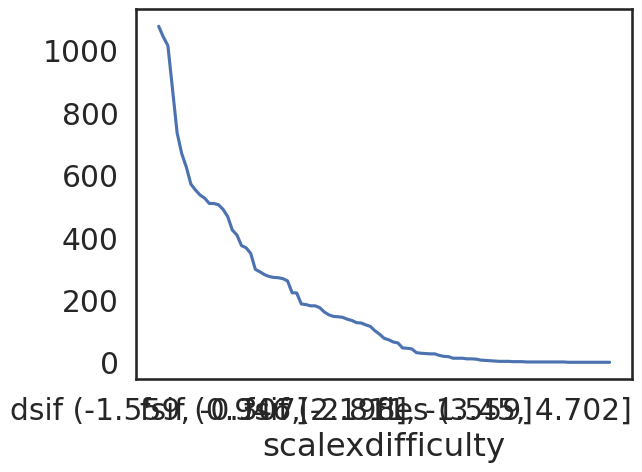

In [18]:
minlevels = 10
#MINSAMPLES = 20
from cluster_utils import compute_clustering_indices
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

dimred = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
#dimred = PCA(whiten=False)

df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                         
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


grouping_variable, target_variable = 'scalexdifficulty', 'matrix'
scores_dict = {'CH': [], 'DB':[], 'N_LEVELS':[], 'N_SAMPLES':[]}
scores = compute_clustering_indices(model, train_data, df_item.copy(), device, grouping_variable, 
                                        target_variable, shuffle=False, seed=0, minsamples=MINSAMPLES)
[ scores_dict[key].append(scores[key]) for key in scores_dict]

scores_df = pd.DataFrame(scores_dict['DB'])        
scores_df = pd.melt(scores_df, value_name='index', var_name=grouping_variable).sort_values('index', ascending=False)

scores_df['N_LEVELS'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_LEVELS'][0][x])
scores_df['N_SAMPLES'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_SAMPLES'][0][x])

scores_df = scores_df.loc[scores_df['N_LEVELS'] >= minlevels]


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=0):
    df_item_ = df_item.reset_index().drop(columns='index')

    df_item_sub = df_item_.loc[df_item_[grouping_variable] == scores_df.iloc[k][grouping_variable]]
    
    # look only at those with a minimum of samples
    tab = df_item_sub[target_variable].value_counts()
    print(tab)
    #ind = tab[tab >= minsamples].index
    ind = tab[:4].index
    df_item_sub = df_item_sub.loc[df_item_sub[target_variable].isin(ind).values]
    if target_variable == 'matrix':
        df_item_sub['labels'] = df_item_sub[target_variable].apply(lambda x: '.'.join(x.split('.')[2:]))
    else:
        df_item_sub['labels'] = df_item_sub[target_variable]
    print(df_item_sub[target_variable].value_counts())
    data = data.to(device)

    z_dict = model.get_embeddings(data, encoded=True)
    embedding = z_dict['item'].detach().cpu().numpy()
    #dimred.fit(embedding)
    #low_dim = dimred.transform(embedding)

    low_dim = dimred.fit_transform(embedding)
    low_dim = low_dim[df_item_sub.index, :]

    X = df_item_sub #.loc[select, :]

    #X['domain'] = X['domain'].apply(lambda x: DOMAIN_LABELS[x])

    X['x'] = low_dim[:, 0]
    X['y'] = low_dim[:, 1]
     #   X['z'] = low_dim[:, 2]

    fig = plt.figure(figsize=(15, 7))
    axes = sns.scatterplot(data=X, x='x', y='y', hue='labels', s=100, alpha=0.7) 
    axes.legend(prop = { 'size': 16 })
    plt.show()

    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
    clustering.fit(low_dim)

    fig = plt.figure(figsize=(15, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram

    plot_dendrogram(clustering, truncate_mode="level", p=10, labels=df_item_sub['labels'].values)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    
#for k in range(4):
#    plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=k)


In [19]:
scores_df


,scalexdifficulty,index,N_LEVELS,N_SAMPLES
25,"esif (0.946, 2.198]",0.145241,12,263
49,"mgfz (0.946, 2.198]",0.143266,16,313
50,"mgfz (-0.307, 0.946]",0.137954,27,533
24,"esif (-1.559, -0.307]",0.134454,10,232
43,"mzuv (-2.811, -1.559]",0.132593,22,364
44,"ehoe (-1.559, -0.307]",0.128356,12,238
35,"mfur (0.946, 2.198]",0.128041,15,342
15,"mzuv (0.946, 2.198]",0.123533,17,320
33,"mfur (-0.307, 0.946]",0.122927,18,358
53,"mgfz (-2.811, -1.559]",0.122815,15,252


# represent embeddings before and after the GNN encoder
visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [20]:
scores_dict = {
    'matrix':{'CH': [], 'SH': [], 'DB':[]},
    'topic':{'CH': [], 'SH': [], 'DB':[]}
    }
distances_dict = {'within': [], 'between': []}
mean_distance_list = []
#NPERMS = 10
# perm == 0 is unshuffled
for perm in range(NPERMS):
    scores_matrix, scores_topic, within_domain, between_domain, mean_distances, unique_scales, within_between_scales = evaluate_items(model, train_data, df_item, device, 
                                                                           shuffle=perm>0, 
                                                                           seed=0, 
                                                                           minsamples=MINSAMPLES)
    
    [ scores_dict['matrix'][key].append(scores_matrix[key]) for key in scores_dict['matrix']]
    [ scores_dict['topic'][key].append(scores_matrix[key]) for key in scores_dict['topic']]
    distances_dict['within'].append(within_domain)
    distances_dict['between'].append(between_domain)
    mean_distance_list.append(within_between_scales)

scale
dsif    6813
mzuv    6421
mgfz    4801
mfur    3479
dles    3130
esif    2507
fsif    2213
eles    1918
ehoe    1491
fles    1383
fhoe     931
Name: count, dtype: int64
scale
dles    500
dsif    500
ehoe    500
eles    500
esif    500
fhoe    500
fles    500
fsif    500
mfur    500
mgfz    500
mzuv    500
Name: count, dtype: int64


In [21]:
distances_df = pd.DataFrame(np.concatenate(mean_distance_list), columns=unique_scales) 
distances_df['perm'] = distances_df.index // len(unique_scales)
distances_df['random'] = 'Observed\n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled\n data'
distances_df['within_between'] = 'between'
distances_df.loc[ distances_df.index % len(unique_scales) == 0, 'within_between'] = 'within'

distances_df = distances_df.groupby(['perm','within_between','random'])[unique_scales].mean().reset_index()
distances_df = pd.melt(distances_df, id_vars=['perm','within_between','random'], value_name='distance', var_name='scale')

# between - within distance should be positive
distances_df['diff'] = distances_df['distance'] 
aux = distances_df.query('`within_between` == "between"').copy().reset_index()
within = distances_df.query('`within_between` == "within"').reset_index()['distance']
aux['diff'] = (aux['diff'] - within)/within*100

distances_df = aux.drop(columns='within_between').sort_values(by=['scale', 'random'])


In [22]:
distances_df.query('perm == 0' )

,index,perm,random,scale,distance,diff
70,140,0,Observed\n data,dles,7.034208,35.595727
30,60,0,Observed\n data,dsif,6.869295,33.228901
90,180,0,Observed\n data,ehoe,6.915677,23.999525
60,120,0,Observed\n data,eles,7.073606,13.747041
40,80,0,Observed\n data,esif,8.278789,-5.712811
0,0,0,Observed\n data,fhoe,7.754456,3.122530
10,20,0,Observed\n data,fles,6.816852,27.076278
50,100,0,Observed\n data,fsif,7.170318,11.763139
80,160,0,Observed\n data,mfur,8.469973,-5.475984
100,200,0,Observed\n data,mgfz,8.545592,-5.764333


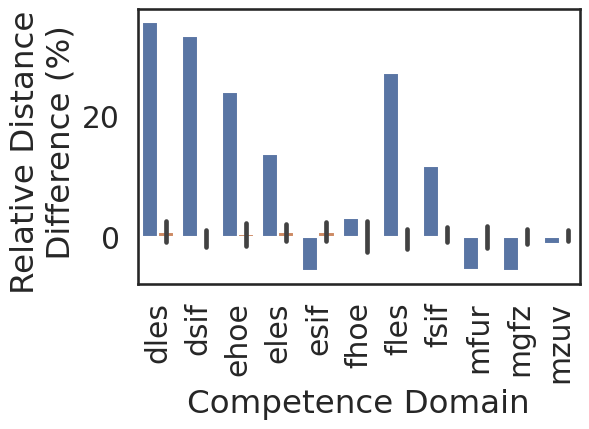

In [23]:
fig = plt.figure()
axes = sns.barplot(data=distances_df, x='scale', y='diff', hue='random', errorbar='sd')
axes.legend_.remove()
axes.tick_params(axis='x', rotation=90)
axes.set(xlabel='Competence Domain', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_scale_distance_bw.png', dpi=DPI)

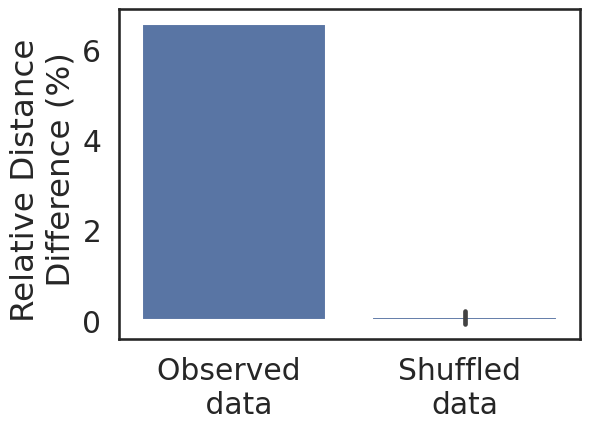

In [24]:
distances_df = pd.DataFrame(distances_dict)
distances_df['perm'] = distances_df.index
#distances_df = pd.melt(distances_df, id_vars='perm', value_name='index', var_name='group')
distances_df['random'] = 'Observed \n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled \ndata'
distances_df['diff'] = (distances_df['between'] - distances_df['within'] )/distances_df['within']*100

fig = plt.figure()
ax = sns.barplot(data=distances_df, x='random', y='diff', errorbar='sd')
ax.set(xlabel='', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()

plt.savefig(f'./vis/{FILENAME}_domain_distance_bw.png', dpi=DPI)

In [25]:
distances_df.query('perm == 0' )

,within,between,perm,random,diff
0,7.145446,7.613721,0,Observed \n data,6.553472


In [26]:
#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#from matplotlib.category import UnitData

for variable in ['matrix']: # , 'topic'
    for i, index in enumerate(['CH', 'DB']): #scores_dict
        fig = plt.figure(figsize=(FIGSIZE))

        scores_df = pd.DataFrame(scores_dict[variable][index])
        scores_df['perm'] = scores_df.index
        scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name='scale')
        scores_df['random'] = 'Observed data'
        scores_df.loc[ scores_df['perm'] > 0, 'random'] = 'Shuffled data'
        #plt.figure()
        scores_df['scale'] = pd.Categorical(scores_df['scale'], categories=np.sort(scores_df.scale.unique()))
        axes = sns.barplot(data=scores_df, x='scale', y='index', hue='random', errorbar='sd')
        axes.legend_.remove()
        axes.set_xlabel('Competence Domain')
        axes.set_ylabel('Cluster Validity Index')
        axes.set_title(CLUSTER_LABELS[index])
        axes.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.savefig(f'./vis/{FILENAME}_{variable}_bw_random_{index}.png', dpi=DPI)
        plt.close()
        print(scores_df.query('perm == 0'))

     perm scale      index         random
0       0  fhoe   2.517847  Observed data
10      0  fles   3.765976  Observed data
20      0  mzuv  10.674033  Observed data
30      0  dsif  10.643983  Observed data
40      0  esif  20.857080  Observed data
50      0  fsif  11.839902  Observed data
60      0  eles   4.684318  Observed data
70      0  dles   4.901928  Observed data
80      0  mfur  22.989553  Observed data
90      0  ehoe   7.219862  Observed data
100     0  mgfz  13.946441  Observed data
     perm scale     index         random
0       0  fhoe  0.122470  Observed data
10      0  fles  0.087752  Observed data
20      0  mzuv  0.105939  Observed data
30      0  dsif  0.080103  Observed data
40      0  esif  0.144938  Observed data
50      0  fsif  0.116257  Observed data
60      0  eles  0.082783  Observed data
70      0  dles  0.083294  Observed data
80      0  mfur  0.111927  Observed data
90      0  ehoe  0.108527  Observed data
100     0  mgfz  0.115742  Observed data


<Axes: xlabel='scalexdifficulty'>

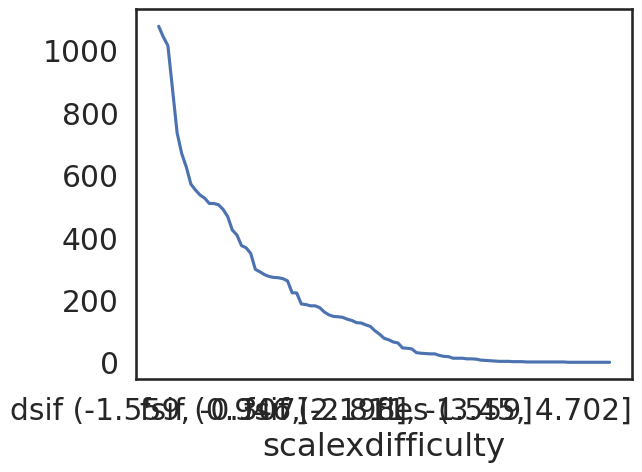

In [27]:
df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                         
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()

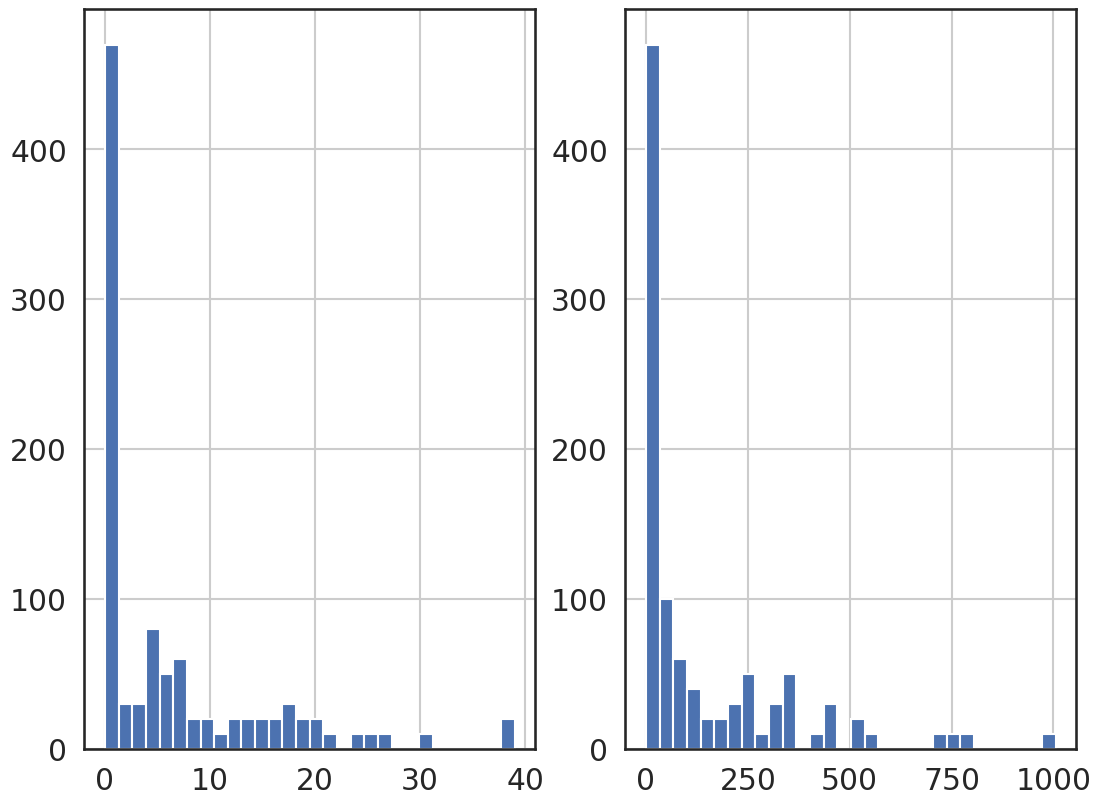

(250, 5)
(250, 10)
['fles' 'mzuv' 'dsif' 'esif' 'eles' 'dles' 'mfur' 'mgfz' 'ehoe']
0 fles
1 mzuv
2 dsif
3 esif
4 eles
5 dles
6 mfur
7 mgfz
8 ehoe


/home/garben/Modelling-Students-Learning/vis_utils.py:629: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7f7a542a5850> starts with '_'. It is thus excluded from the legend.
  fig.legend( labels=['Significance \nthreshold \n(uncorrected)',
/home/garben/Modelling-Students-Learning/vis_utils.py:629: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f7a543f0340> starts with '_'. It is thus excluded from the legend.
  fig.legend( labels=['Significance \nthreshold \n(uncorrected)',
/home/garben/Modelling-Students-Learning/vis_utils.py:629: UserWarning: The label '_' of <matplotlib.collections.PathCollection object at 0x7f7a543de910> starts with '_'. It is thus excluded from the legend.
  fig.legend( labels=['Significance \nthreshold \n(uncorrected)',
/home/garben/Modelling-Students-Learning/vis_utils.py:629: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f7a54b08d60> starts with '_'. It is thus excluded from the legend

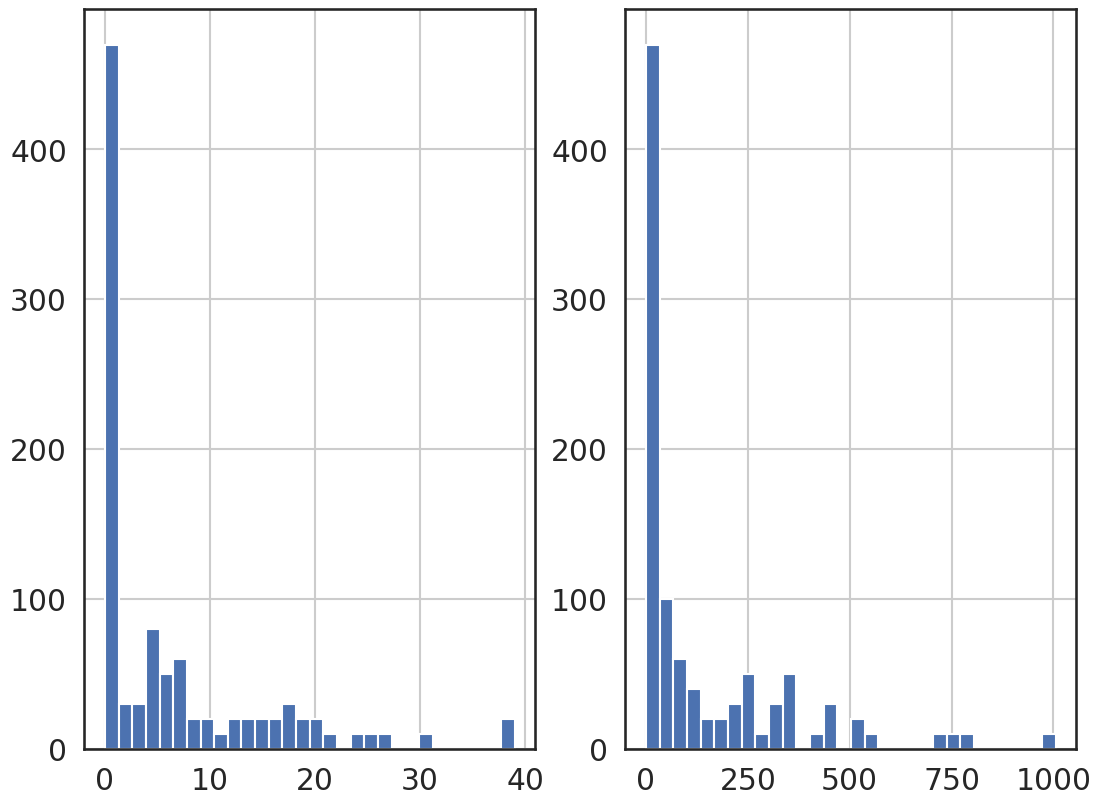

(250, 5)
(250, 10)
['fles' 'mzuv' 'dsif' 'esif' 'eles' 'dles' 'mfur' 'mgfz' 'ehoe']
0 fles
1 mzuv
2 dsif
3 esif
4 eles
5 dles
6 mfur
7 mgfz
8 ehoe


In [28]:
#plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
#                nperms=NPERMS)

#%load_ext autoreload
#%autoreload 2
#from vis_utils import plot_clustering
plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
#if DATASET in ['matrix', 'topic']:
#    sys.exit()

[-0.0491911  -0.03111529  0.04614223  0.09989719  0.13847362  0.38005337
 -0.20587216 -0.06501205  0.2427485   0.07136165  0.2673469   0.11082559]
[1.115546  1.2196283 1.2073606 1.2878957 1.1427402 1.1914604 1.1536287
 1.2742419 1.150556  1.1665194 1.1194732 1.1715219]


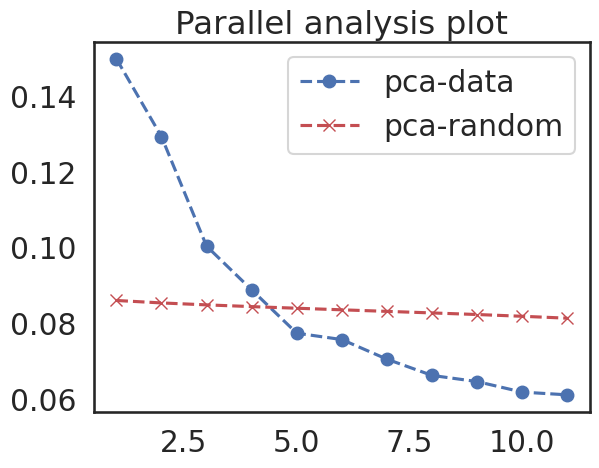

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

[16.314098  12.456984   9.9956255  8.774306   7.204134   7.1842766
  6.8950586  6.5878487  6.2665873  6.207496   6.13268    5.9809   ]
[ 16.314098  28.771082  38.766705  47.54101   54.745144  61.929424
  68.82448   75.41233   81.678925  87.88641   94.0191   100.      ]
[ 1.299104    0.3413739   0.89885753  1.0291849   1.1986594  -0.30854508
  0.08573863  0.9553456   1.1006926   0.57340646  1.5502384  -0.11726821]
[1.2625924 2.8520699 1.854948  1.6075103 1.5643126 1.1707325 2.330289
 2.5727882 0.8270899 1.371126  1.702712  1.3223932]


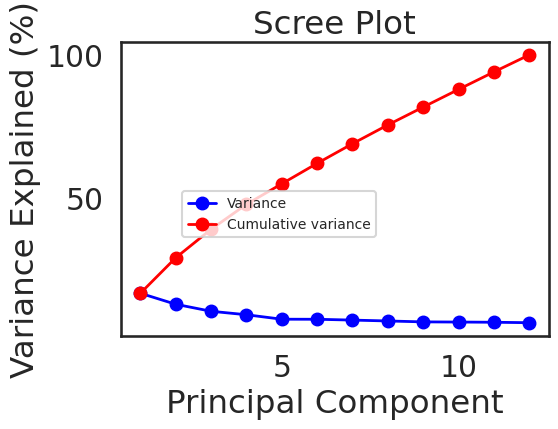

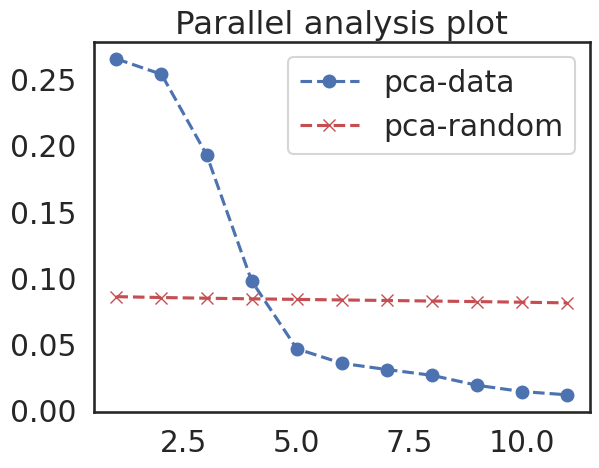

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

[31.542904   24.68442    19.795334    7.1601562   4.9001017   3.7659373
  3.0580628   2.1570842   1.0589281   0.9601758   0.753737    0.16315427]
[ 31.542904  56.22732   76.02265   83.182816  88.08292   91.84885
  94.90691   97.064     98.12293   99.08311   99.836845 100.      ]


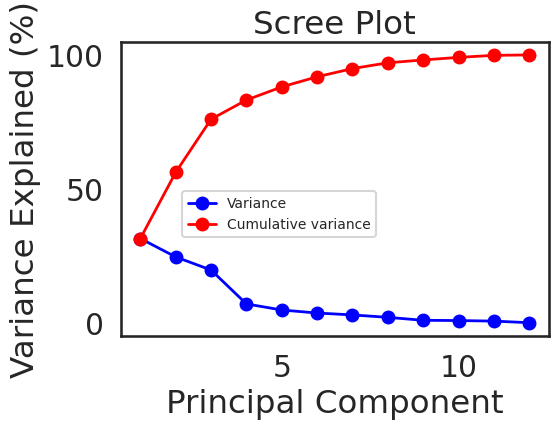

In [29]:
# represent embeddings before and after the GNN encoder
visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [30]:
#visualize_students(model, train_data, device, df_student, FILENAME, equal_axes=EQUAL_AXES)

In [31]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=True, aggregate=True, AGE_THR=AGE_THR)

In [32]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=False, aggregate=False, AGE_THR=AGE_THR)